In [1]:
import numpy as np
import random

from math import log2, ceil

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from joblib import Parallel, delayed

from proglearn.forest import LifelongClassificationForest, UncertaintyForest
from proglearn.sims import *
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage, KNNClassificationDecider, KNNSimpleClassificationDecider
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
import functions.xor_rxor_with_KNN_functions as fn
from proglearn.sims import generate_gaussian_parity

Using TensorFlow backend.
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\progl

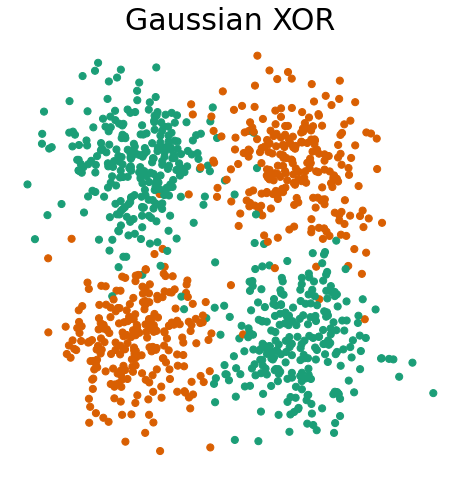

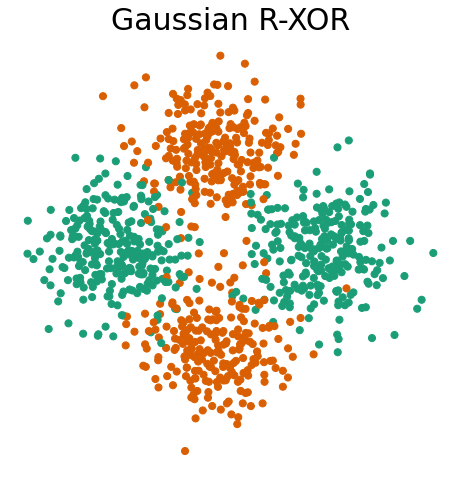

In [2]:
# call function to return gaussian xor and r-xor data:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi/4)

X, Y = generate_gaussian_parity(750, angle_params=0)
Z, W = generate_gaussian_parity(1000, angle_params=np.pi/4)

# plot and format:
fn.plot_xor_rxor(X_xor, y_xor, 'Gaussian XOR')
fn.plot_xor_rxor(X_rxor, y_rxor, 'Gaussian R-XOR')

In [3]:
# define hyperparameters:
mc_rep = 100 # 1000 in paper experiment
n_test = 1000 
n_trees = 10
n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_rxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

## Various Angles vs BTE

First, we'll set the variables we'll use:
- `mc_rep`: number of repetitions to run the progressive learning algorithm for
- `angle_sweep`: angles to test
- `task1_sample`: number of task 1 samples
- `task2_sample`: number of task 2 samples

In [4]:
angle_sweep = range(0,46,5)
angle_sweep = [x*np.pi/180 for x in angle_sweep]
task1_sample = 1000
task2_sample = 1000
mc_rep = 100
k_neighbors = [1,3,5,9,17,33]
n_test = 1000
max_depth = 10

In [5]:
# Initiate error arrays
mean_error_bte = np.zeros((len(k_neighbors), len(angle_sweep)))

# Initiate transfer efficiency arrays
mean_bte = np.zeros((len(k_neighbors), len(angle_sweep)))

for i, n1 in enumerate(k_neighbors):
    # Create the error.
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(fn.experiment_KNN_BTE)(
                task1_sample, task2_sample, n_test, angle_sweep,
                n_trees, max_depth, n1, random_state=0, simple=2) for _ in range(mc_rep)
            )
        )

    mean_error_bte[i] = np.mean(error, axis=0)
    mean_bte[i] = mean_error_bte[i,0] / mean_error_bte[i]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Don

In [6]:
# Initiate error arrays
mean_error_bte_SA = np.zeros((len(angle_sweep)))

# Initiate transfer efficiency arrays
mean_bte_SA = np.zeros((len(angle_sweep)))

# Create the error.
error = np.array(
    Parallel(n_jobs=-1, verbose=1)(
        delayed(fn.experiment_KNN_BTE)(
            task1_sample, task2_sample, n_test, angle_sweep,
            n_trees, max_depth, random_state=0, simple=0) for _ in range(mc_rep)
        )
)

mean_error_bte_SA = np.mean(error, axis=0)
mean_bte_SA = mean_error_bte_SA[0] / mean_error_bte_SA

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.3s finished


Text(0.5, 1.0, 'Setting 1: Least Adversarial to Most')

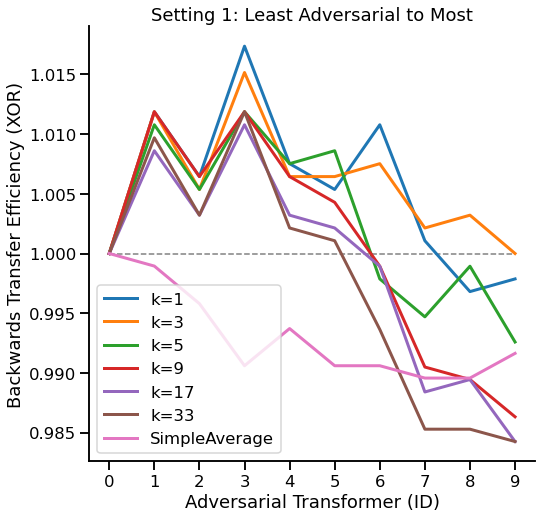

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

ran = range(0,10,1)

sns.set_context("talk")
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(ran,mean_bte[0,:],linewidth = 3)
ax.plot(ran,mean_bte[1,:],linewidth = 3)
ax.plot(ran,mean_bte[2,:],linewidth = 3)
ax.plot(ran,mean_bte[3,:],linewidth = 3)
ax.plot(ran,mean_bte[4,:],linewidth = 3)
ax.plot(ran,mean_bte[5,:],linewidth = 3)
ax.plot(ran, mean_bte_SA,linewidth = 3)
labels = ['k=1', 'k=3','k=5','k=9','k=17','k=33', 'SimpleAverage']

ax.legend(labels)

ax.set_xticks(ran)
ax.set_xlabel('Adversarial Transformer (ID)')
ax.set_ylabel('Backwards Transfer Efficiency (XOR)')
ax.hlines(1, 0,9, colors='gray', linestyles='dashed',linewidth=1.5)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_title('Setting 1: Least Adversarial to Most')